## Cvičení 

V notebooku se nachází jednoduché dílčí úkoly. Některé z nich jsou zakonenčeny asserty, pokud vám asserty nebudou procházet - pravděpodobně máte něco špatně nebo jste nepostupovali podle zadání. Pokud asserty prochází, neznamená to, že to máte nutně správně. Úkoly na sebe navazují, proto se ujistěte, že jste splnili zadání, než se posunete dál.

Notebook bude umět:
- Přijímat parametry, např. z Azure Data Factory.
- Načíst data o testech a populaci v ČR z Azure Blob Storage do pyspark DataFrame (pozor, není to samé jako pandas DataFrame!)
- S DataFrami dále pracovat, provést jednoduchou analýzu dat.
- Data vizualizovat.

### Nastavení výchozích hodnot parametrů

#### Úkol :
- Výchozí hodnoty nastavte podle toho, jak jste si pojmenovali váš Storage Account, kontejnery
  - vyplňte váš *storage_account_access_key*
  - *directory* ideálně nastavte na nějaká data (zpracovaná vaší pipelinou) z minulosti, abyste mohli notebook spouštět i bez spuštění celé pipeline
    - pokud taková data nemáte, spusťte vaší pipeline - výstupem prvních dvou aktivit by měl být adresář ve vaší storage - jeho jméno použijte jako výchozí hodnotu
    - že data nemusí být aktuální nevadí, protože výchozí hodnotu budeme používat jen pro testovací účely

In [0]:
dbutils.widgets.removeAll()

In [0]:
dbutils.widgets.text("storage_account_name", "covidstoragex") # the name of your default storage account
dbutils.widgets.text("storage_account_access_key", "hz+2hsxIbjJy1MI7BCk8vg1yY7IaLuKGhmVwXEXU+lwPzEGbdNLVTE10PVtpfnTBvyshkK2QuaWy9Pojy5I1KQ==")
dbutils.widgets.text("container_name", "cumulative-tests")

# if you already have some directory with joined covid data, you can set it as default value so you can test the notebook without running the pipeline
dbutils.widgets.text("directory", "covid_tests_joined-2021-12-01T13-14-49.1168452Z")


##### Načtení parametrů z ADF (pokud jsou)
V případě, že notebook spouštíte manuálně nebo bez parametrů, použijí se výchozí hodnoty.

In [0]:
storage_account_name = dbutils.widgets.get("storage_account_name")
storage_account_access_key = dbutils.widgets.get("storage_account_access_key")
directory = dbutils.widgets.get("directory")
container_name = dbutils.widgets.get("container_name")

print(directory)

covid_tests_joined-2021-12-01T13-14-49.1168452Z

### Mounting kontejnerů
Abychom mohli pracovat se soubory co máme v Azure Blob Storage, namountujeme si danné kontejnery do DBFS.
Mount je pointer na kontejner. Pro připojení využijeme Access key, který předáme jako parametr z ADF. Není to nejbezpečnější možnost ale pro naše účely postačující, více informací o mountování Azure Storage např. [zde](https://docs.microsoft.com/en-us/azure/databricks/data/data-sources/azure/azure-storage).

In [0]:
# helper function which checks if a certain path is contained in current mounts, and if yes, unmounts it
def sub_unmount(str_path):
    if any(mount.mountPoint == str_path for mount in dbutils.fs.mounts()):
        dbutils.fs.unmount(str_path)

In [0]:
# mounts the countainer to specified mount_point, unless the mount_point already exists
def mount(source_url, mount_point, extra_configs):
    
    if not any(mount.mountPoint == mount_point for mount in dbutils.fs.mounts()):
        # mount point does not exist yet
       
        return dbutils.fs.mount(source = source_url,
                         mount_point = mount_point,
                         extra_configs = extra_configs)
     
    else:
        # do things you want to do if the mount point already exists
        return True

##### Sestavení parametrů a mount

In [0]:
# build the urls of our containers using a set of well-defined rules
source_url_tests = f"wasbs://{container_name}@{storage_account_name}.blob.core.windows.net/"

# where to mount the container
mount_point_tests = "/mnt/tests-data"

# access
extra_configs = {f"fs.azure.account.key.{storage_account_name}.blob.core.windows.net":storage_account_access_key}

# MOUNT IT!
assert mount(source_url_tests, mount_point_tests, extra_configs)

#### Úkol :
- Stejným způsobem namountujte i kontejner obsahující data o populaci v krajích ČR. (Soubor byste měli mít stažený a umístěný v kontejneru spolu s Excel sheetem, který jsme používali v data flow.)

In [0]:
container_name_static_data = "static-data"

# ---------------------------------------
# WRITE YOUR CODE HERE:

source_url_static_data = "wasbs://static-data@covidstoragex.blob.core.windows.net/"
mount_point_static_data = "/mnt/static-data"

# ---------------------------------------

# (extra_configs are the same as above)
mount(source_url_static_data, mount_point_static_data, extra_configs)

assert len(dbutils.fs.mounts()) > 1

Po namountování kontejnerů můžeme použít DataBricks utility pro práci s filesystémem, abychom si vylistovali obsah namountovaného kontejneru a ověřili si, že se kontejner namountoval správně.

#### Úkol:
- Použijte příkaz **dbutils.fs.help()** pro zobrazení utilit pro práci s filesystémem.
- Pomocí vhodné utility vylistujte obsah alespoň jednoho z kontejnerů.

In [0]:
# dbutils.fs.help()
# ---------------------------------------
# WRITE YOUR CODE HERE:
dbutils.fs.ls(f"dbfs:{mount_point_static_data}")
# ---------------------------------------

Out[8]: [FileInfo(path='dbfs:/mnt/static-data/CZ AREA CODES.xlsx', name='CZ AREA CODES.xlsx', size=9108),
 FileInfo(path='dbfs:/mnt/static-data/czech_population.csv', name='czech_population.csv', size=718)]

## Načtení dat

Načteme data z konkrétního adresáře v našem kontejneru (využijeme k tomu vytvořený mount point) do DataFrame. Následně vytiskneme jeho schema.

In [0]:
# read the data about tests to dataframe
tests_df = spark.read\
    .option("header","true")\
    .option("inferSchema", "true")\
    .csv(f"{mount_point_tests}/{directory}")

# print the schema, check how the column types were infered
tests_df.printSchema() 

# check what type it is
print(type(tests_df))


root
-- id: string (nullable = true)
-- datum: string (nullable = true)
-- kraj_nuts_kod: string (nullable = true)
-- okres_lau_kod: string (nullable = true)
-- prirustkovy_pocet_testu_okres: integer (nullable = true)
-- kumulativni_pocet_testu_okres: integer (nullable = true)
-- prirustkovy_pocet_testu_kraj: integer (nullable = true)
-- kumulativni_pocet_testu_kraj: integer (nullable = true)
-- prirustkovy_pocet_prvnich_testu_okres: integer (nullable = true)
-- kumulativni_pocet_prvnich_testu_okres: integer (nullable = true)
-- prirustkovy_pocet_prvnich_testu_kraj: integer (nullable = true)
-- kumulativni_pocet_prvnich_testu_kraj: integer (nullable = true)
-- nazev_kraje: string (nullable = true)
-- nazev_okresu: string (nullable = true)
-- CZ-NUTS3: string (nullable = true)
-- CZ-NUTS4: string (nullable = true)

<class 'pyspark.sql.dataframe.DataFrame'>

#### Úkol : 
- Načtěte data s údaji o populaci do dataframe, pojmenujte jej *population_df*.
- Dropněte sloupce *male_population*, *female_population*, *nazev_kraje* - nebudeme je potřebovat. [Můžete se inspirovat třeba zde.](https://towardsdatascience.com/delete-columns-pyspark-df-ba9272db1bb4)
- Zobrazte schema dataframu (měl by mít 2 sloupce - kód kraje a jeho populaci).

In [0]:
population_filename = "czech_population.csv"

# ---------------------------------------
# WRITE YOUR CODE HERE:
population_df = spark.read.option("header","true").csv(f"{mount_point_static_data}/{population_filename}")
cols_to_drop = ['male_population', 'female_population', 'nazev_kraje']
population_df = population_df.drop(*cols_to_drop)
population_df.printSchema() 

# ---------------------------------------

df_shape = (population_df.count(), len(population_df.columns))
assert df_shape == (14, 2)

root
-- CZ-NUTS3: string (nullable = true)
-- total_population: string (nullable = true)

#### Funkce display

Databricks nabízí vestavěnou funkci **display**. Slouží k hezké vizualizaci dat - pomocí tabulek či nejrůznějších grafů. [Více o vizualizacích pomocí display si můžete přečíst zde.](https://docs.databricks.com/notebooks/visualizations/index.html)

In [0]:
display(tests_df)

id datum kraj_nuts_kod okres_lau_kod prirustkovy_pocet_testu_okres kumulativni_pocet_testu_okres prirustkovy_pocet_testu_kraj kumulativni_pocet_testu_kraj prirustkovy_pocet_prvnich_testu_okres kumulativni_pocet_prvnich_testu_okres prirustkovy_pocet_prvnich_testu_kraj kumulativni_pocet_prvnich_testu_kraj nazev_kraje nazev_okresu CZ-NUTS3 CZ-NUTS4 e621982e-7e1b-4e8d-af58-406417cdc15a 2020-08-01 CZ010 CZ0100 1281 1281 1281 1281 941 941 941 941 Hlavní město Praha Hlavní město Praha CZ010 CZ0100 9cefc5ef-f4b1-45eb-b0e5-503935a3233d 2020-08-01 CZ020 CZ020A 159 159 671 671 120 120 490 490 Středočeský kraj Praha-západ CZ020 CZ020A 65394534-34b1-43eb-8879-f1b7c7aab877 2020-08-01 CZ020 CZ020B 18 18 671 671 12 12 490 490 Středočeský kraj Příbram CZ020 CZ020B f561fcf1-674a-4404-b2a5-1ec12f1c3b41 2020-08-01 CZ020 CZ020C 11 11 671 671 8 8 490 490 Středočeský kraj Rakovník CZ020 CZ020C 20753bad-5e40-46a6-a47d-49f817cd4504 2020-08-01 CZ020 CZ0201 17 17 671 671 14 14 490 490 Středočeský kraj Benešov CZ020 CZ0201 ceafd75f-d512-48aa-a8f3-a8fa0f2fd638 2020-08-01 CZ020 CZ0202 62 62 671 671 48 48 490 490 Středočeský kraj Beroun CZ020 CZ0202 ef3dc387-d096-41f8-80db-de8dac912d4d 2020-08-01 CZ020 CZ0203 33 33 671 671 29 29 490 490 Středočeský kraj Kladno CZ020 CZ0203 6c9feef4-e2ea-40ff-9a34-76d3a3bc3eb7 2020-08-01 CZ020 CZ0204 58 58 671 671 49 49 490 490 Středočeský kraj Kolín CZ020 CZ0204 a4f00169-148b-4a1a-9748-b856526a11df 2020-08-01 CZ020 CZ0205 8 8 671 671 7 7 490 490 Středočeský kraj Kutná Hora CZ020 CZ0205 4745b5d7-1abe-4ac3-896d-badac83ec7cb 2020-08-01 CZ020 CZ0206 65 65 671 671 48 48 490 490 Středočeský kraj Mělník CZ020 CZ0206 09c11216-634b-4230-a5a4-ecea5c2c5cdb 2020-08-01 CZ020 CZ0207 61 61 671 671 45 45 490 490 Středočeský kraj Mladá Boleslav CZ020 CZ0207 29334f97-a010-4967-a41e-bfdc5d5499eb 2020-08-01 CZ020 CZ0208 62 62 671 671 35 35 490 490 Středočeský kraj Nymburk CZ020 CZ0208 d700be16-3f26-422e-a0ba-6d6f15e544bc 2020-08-01 CZ020 CZ0209 117 117 671 671 75 75 490 490 Středočeský kraj Praha-východ CZ020 CZ0209 74720011-2ea4-4853-a667-af40dcb5d0ef 2020-08-01 CZ031 CZ0311 26 26 181 181 26 26 168 168 Jihočeský kraj České Budějovice CZ031 CZ0311 7259f916-1328-43c6-adad-3fe786185209 2020-08-01 CZ031 CZ0312 1 1 181 181 1 1 168 168 Jihočeský kraj Český Krumlov CZ031 CZ0312 0b19b833-d25d-4bcc-b4bb-f52395c41aa6 2020-08-01 CZ031 CZ0313 13 13 181 181 7 7 168 168 Jihočeský kraj Jindřichův Hradec CZ031 CZ0313 f46c5de9-e168-4a93-a742-2c838b3203b4 2020-08-01 CZ031 CZ0314 8 8 181 181 5 5 168 168 Jihočeský kraj Písek CZ031 CZ0314 f64c8b99-a031-4891-94f6-0095d63cff3b 2020-08-01 CZ031 CZ0315 68 68 181 181 67 67 168 168 Jihočeský kraj Prachatice CZ031 CZ0315 9a94c911-9383-486d-83b7-1d4ce59e4ba9 2020-08-01 CZ031 CZ0316 29 29 181 181 28 28 168 168 Jihočeský kraj Strakonice CZ031 CZ0316 89bfdc72-207e-4a20-8115-81d7090b683c 2020-08-01 CZ031 CZ0317 36 36 181 181 34 34 168 168 Jihočeský kraj Tábor CZ031 CZ0317 0e537d3a-375f-486c-8a7c-5f950eebe76b 2020-08-01 CZ032 CZ0321 10 10 143 143 9 9 132 132 Plzeňský kraj Domažlice CZ032 CZ0321 962220c7-87da-47c9-8987-22ec797ffc16 2020-08-01 CZ032 CZ0322 8 8 143 143 8 8 132 132 Plzeňský kraj Klatovy CZ032 CZ0322 45edf380-4fc0-4908-83fb-50732ce20e3b 2020-08-01 CZ032 CZ0323 55 55 143 143 49 49 132 132 Plzeňský kraj Plzeň-město CZ032 CZ0323 f1c7c92b-079f-46ee-bf48-e1263984fd59 2020-08-01 CZ032 CZ0324 23 23 143 143 22 22 132 132 Plzeňský kraj Plzeň-jih CZ032 CZ0324 4561be49-cc4b-4c96-a6c8-d58a6f4f7269 2020-08-01 CZ032 CZ0325 17 17 143 143 14 14 132 132 Plzeňský kraj Plzeň-sever CZ032 CZ0325 4f7e211f-1501-4b4e-8a93-664e629a0980 2020-08-01 CZ032 CZ0326 19 19 143 143 19 19 132 132 Plzeňský kraj Rokycany CZ032 CZ0326 05f39e68-0069-4f34-a947-b109a3e3233a 2020-08-01 CZ032 CZ0327 11 11 143 143 11 11 132 132 Plzeňský kraj Tachov CZ032 CZ0327 9db6518d-5abf-46f4-af31-ca2f541853b3 2020-08-01 CZ041 CZ0411 27 27 51 51 11 11 29 29 Karlovarský kraj Cheb CZ041 CZ0411 7935443d-54eb-479c-9b70-38328d7a7594 2020-08-01 CZ041 CZ0412 15 15 51 51 12 12 

#### Úkol :
- Vytvořte DataFrame se jménem *total_tests_per_district_df*, který bude obsahovat 3 sloupce:
  - název kraje
  - jeho CZ-NUTS3 kód
  - kolik bylo v kraji celkem provedeno testů (nejaktuálnější údaj)
    - můžete např. vzít maximum ze sloupce počtu kumulativních testů pro každý kraj
- Sloupec s testy pojmenujte *total_tests*.
- Seřaďte záznamy v DataFramu sestupně podle počtu provedených testů.
- Zobrazte výsledný DataFrame funkcí display.
- Zkontrolujte, jestli prochází asserty.

Užitečné funkce: [groupBy](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.groupBy.html), max, withColumnRenamed, orderBy/sort,

In [0]:
from pyspark.sql.functions import col
import pyspark.sql.functions as f

# ---------------------------------------
# WRITE YOUR CODE HERE:
total_tests_per_district_df = tests_df.select([col for col in ['nazev_kraje', 'CZ-NUTS3', 'kumulativni_pocet_prvnich_testu_kraj']])
total_tests_per_district_df = total_tests_per_district_df.groupBy('CZ-NUTS3').agg(f.max('kumulativni_pocet_prvnich_testu_kraj').alias('total_tests'))
nazev_df = tests_df.select('nazev_kraje', 'CZ-NUTS3').distinct()
total_tests_per_district_df = total_tests_per_district_df.join(nazev_df, on='CZ-NUTS3').orderBy(col("total_tests").desc())
display(total_tests_per_district_df)
# ---------------------------------------

df_shape = (total_tests_per_district_df.count(), len(total_tests_per_district_df.columns))
assert df_shape == (14, 3)
assert total_tests_per_district_df.collect()[0].total_tests > total_tests_per_district_df.collect()[13].total_tests

CZ-NUTS3 total_tests nazev_kraje CZ010 2392826 Hlavní město Praha CZ020 1827267 Středočeský kraj CZ080 1433949 Moravskoslezský kraj CZ064 1262642 Jihomoravský kraj CZ042 722654 Ústecký kraj CZ032 627996 Plzeňský kraj CZ031 603163 Jihočeský kraj CZ071 599583 Olomoucký kraj CZ072 576421 Zlínský kraj CZ053 564436 Pardubický kraj CZ052 554806 Královéhradecký kraj CZ063 489377 Kraj Vysočina CZ051 489320 Liberecký kraj CZ041 230539 Karlovarský kraj

#### Přidání sloupce test_ratio :
- Do dataframu s počtem testů dle krajů (*total_tests_per_district_df*) přidáme sloupec *test_ratio*, který bude obsahovat číslo spočtené vzorcem: (testů v kraji)/(testů celkem).
  - Zaokrouhlíme na 4 desetinná místa.

Užitečné funkce: withColumn, [col](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.functions.col.html)

In [0]:
import pyspark.sql.functions as F 

# calculate the total number of tests and store it as integer
total_test_amount = total_tests_per_district_df.agg(F.sum('total_tests')).collect()[0][0]

# calculate the ratio of (tests in district)/(tests total)
total_tests_per_district_df = total_tests_per_district_df.withColumn("test_ratio", F.round(col('total_tests')/total_test_amount,4))

print(total_test_amount)
ratio_sum = total_tests_per_district_df.agg(F.sum("test_ratio")).collect()[0][0]
assert abs(1 - ratio_sum) <= 0.01
collected = total_tests_per_district_df.collect()
assert collected[0].test_ratio > collected[13].test_ratio


for i in range(14):
    assert abs((1/collected[i].test_ratio) * collected[i].total_tests - total_test_amount) <= 5e4

display(total_tests_per_district_df)

12374979

CZ-NUTS3 total_tests nazev_kraje test_ratio CZ010 2392826 Hlavní město Praha 0.1934 CZ020 1827267 Středočeský kraj 0.1477 CZ080 1433949 Moravskoslezský kraj 0.1159 CZ064 1262642 Jihomoravský kraj 0.102 CZ042 722654 Ústecký kraj 0.0584 CZ032 627996 Plzeňský kraj 0.0507 CZ031 603163 Jihočeský kraj 0.0487 CZ071 599583 Olomoucký kraj 0.0485 CZ072 576421 Zlínský kraj 0.0466 CZ053 564436 Pardubický kraj 0.0456 CZ052 554806 Královéhradecký kraj 0.0448 CZ063 489377 Kraj Vysočina 0.0395 CZ051 489320 Liberecký kraj 0.0395 CZ041 230539 Karlovarský kraj 0.0186

#### Úkol :
- Do vašeho DataFramu, který obsahuje data o populaci jednotlivých krajů (*population_df*) přidejte sloupec *population_ratio*, který bude vyjadřovat poměr (lidí v kraji)/(lidí celkem).
  - pomocí funkce round (pyspark.sql.functions.round) hodnoty zakrouhlete na 4 desetinná místa 
- Můžete postupovat obdobně jako při situaci s testy.
- Zkontrolujte, že prochází asserty.

In [0]:
# ---------------------------------------
# WRITE YOUR CODE HERE:
population_df = population_df.withColumn('total_population',population_df['total_population'].cast("float").alias('total_population'))
total_population = population_df.agg(F.sum('total_population')).collect()[0][0]

population_df = population_df.withColumn("population_ratio", F.round(col('total_population')/total_population,4))
# # ---------------------------------------

collected = population_df.collect()

for i in range(0,14):
    assert abs((1/collected[i].population_ratio) * collected[i].total_population - 1e7) <= 2*1e6
display(population_df)

CZ-NUTS3 total_population population_ratio CZ010 1335084.0 0.1248 CZ020 1397997.0 0.1306 CZ031 643551.0 0.0601 CZ032 591041.0 0.0552 CZ041 293311.0 0.0274 CZ042 817004.0 0.0763 CZ051 442476.0 0.0413 CZ052 550803.0 0.0515 CZ053 522856.0 0.0489 CZ063 508852.0 0.0475 CZ064 1195327.0 0.1117 CZ071 630522.0 0.0589 CZ072 580119.0 0.0542 CZ080 1192834.0 0.1115

#### Úkol :
- Pokud se sloupec s **NUTS-3** kódem v obou dataframech *total_tests_per_district_df* a *population_df* jmenuje stejně, jeden z nich přejmenujte.
- Vytvořte nový dataframe *tests_population_df*, který bude spojením *total_tests_per_district_df* a *population_df* na základě kódu kraje.
- Z výsledného dataframu dropněte jeden sloupec s NUTS-3 kódem (za předpokladu, že vám po joinu vznikla tabulka obsahující sloupce s obou zdrojových dataframů).
- Přidejte do dataframu sloupec *similar_ratios*, jehož hodnota bude buď:
  - **True** v případě, že hodnoty *population_ratio* a *test_ratio* se o sebe liší o méně nebo rovno *threshold*
  - **False** liší li se hodnoty o více než je *threshold*
- Význam sloupce *similar_ratios* je odpověď na otázku: Odpovídá zhruba poměr testů v kraji jeho poměrné populaci?
- Zkontrolujte, zda prochází asserty.

Užitečné funkce: join, drop, withColumn, funkce z pyspark.sql.functions jako [when+otherwise](https://spark.apache.org/docs/latest//api/python/reference/api/pyspark.sql.functions.when.html), abs, col

In [0]:
import pyspark.sql.functions as F

threshold = 0.01
# ---------------------------------------
# WRITE YOUR CODE HERE:

population_df = population_df.withColumnRenamed("CZ-NUTS3", "CZ-NUTS3-2")
tests_population_df = population_df.join(total_tests_per_district_df, on=total_tests_per_district_df['CZ-NUTS3']==population_df['CZ-NUTS3-2']).drop('CZ-NUTS3-2')

tests_population_df = tests_population_df.withColumn("similar_ratios", F.when(F.abs(col('test_ratio')-col('population_ratio'))< threshold, "True").otherwise("False"))
# # ---------------------------------------

collected = tests_population_df.collect()

for i in range(14):
    if abs(collected[i].population_ratio-collected[i].test_ratio) <= threshold:
        assert collected[i].similar_ratios in (True, "True")
    else:
        assert collected[i].similar_ratios in (False, "False")

display(tests_population_df)


total_population population_ratio CZ-NUTS3 total_tests nazev_kraje test_ratio similar_ratios 522856.0 0.0489 CZ053 564436 Pardubický kraj 0.0456 True 580119.0 0.0542 CZ072 576421 Zlínský kraj 0.0466 True 591041.0 0.0552 CZ032 627996 Plzeňský kraj 0.0507 True 643551.0 0.0601 CZ031 603163 Jihočeský kraj 0.0487 False 1397997.0 0.1306 CZ020 1827267 Středočeský kraj 0.1477 False 1195327.0 0.1117 CZ064 1262642 Jihomoravský kraj 0.102 True 293311.0 0.0274 CZ041 230539 Karlovarský kraj 0.0186 True 630522.0 0.0589 CZ071 599583 Olomoucký kraj 0.0485 False 1192834.0 0.1115 CZ080 1433949 Moravskoslezský kraj 0.1159 True 817004.0 0.0763 CZ042 722654 Ústecký kraj 0.0584 False 508852.0 0.0475 CZ063 489377 Kraj Vysočina 0.0395 True 442476.0 0.0413 CZ051 489320 Liberecký kraj 0.0395 True 550803.0 0.0515 CZ052 554806 Královéhradecký kraj 0.0448 True 1335084.0 0.1248 CZ010 2392826 Hlavní město Praha 0.1934 False

#### Úkol :

- Udělejte nějakou hezkou vizualizaci dle vlastního uvážení. Jakou vizualizaci a jakým způsobem uděláte je na vás.
- Inspirovat se můžete koláči níže.

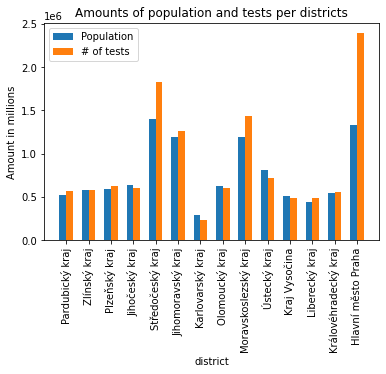

In [0]:
# ---------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

data_pop = tests_population_df.select("total_population").rdd.map(lambda r: r[0]).collect()
data_test = tests_population_df.select("total_tests").rdd.map(lambda r: r[0]).collect()

labels = tests_population_df.select("nazev_kraje").rdd.map(lambda r: r[0]).collect()

fig, ax = plt.subplots()
x = np.arange(len(labels))
width = 0.3
rects1 = ax.bar(x - width/2, data_pop, width, label='Population')
rects2 = ax.bar(x + width/2, data_test, width, label='# of tests')

ax.set_xlabel("district")
ax.set_ylabel('Amount in millions')
ax.set_title('Amounts of population and tests per districts')
ax.set_xticks(np.arange(len(labels)))
ax.tick_params(axis='x', rotation=90)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

# ---------------------------------------

Koláčové grafy vizualizující počty populace/testů dle jednotlivých krajů.

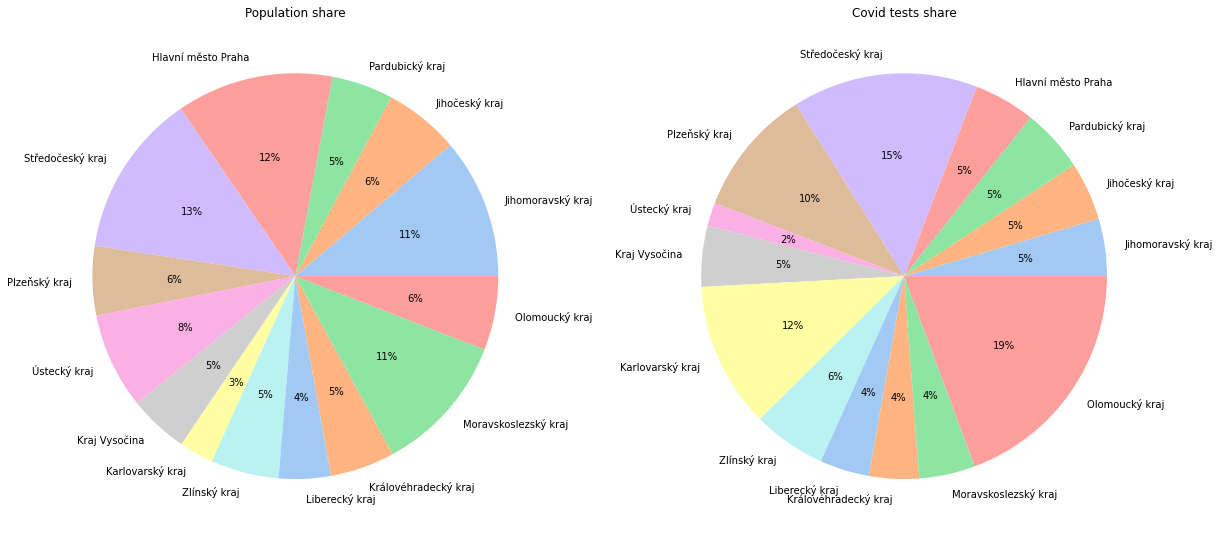

In [0]:
# The Databricks Runtime includes the seaborn visualization library.
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(20,10))

data_pop = tests_population_df.select("total_population").rdd.map(lambda r: r[0]).collect()
data_test = tests_population_df.select("total_tests").rdd.map(lambda r: r[0]).collect()

labels = tests_population_df.select("nazev_kraje").rdd.map(lambda r: r[0]).collect()

#define Seaborn color palette to use
colors = sns.color_palette('pastel')

#create pie chart
ax[0].pie(data_pop, labels = labels, colors = colors, autopct='%.0f%%')
ax[0].set_title("Population share")

ax[1].pie(data_test, labels = labels, colors = colors, autopct='%.0f%%')
ax[1].set_title("Covid tests share")
fig.show()